# Get the distances and risks

In [2]:
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plot
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import cv2
import yaml
import seaborn as sns
import re
from scipy.optimize import minimize


FPS = 15

c:\Users\plima\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
CSVs = glob.glob('./results/*.csv')
CSVs

with open("calibration_matrix.yaml", "r") as f:
    data = yaml.safe_load(f)
data

h,  w = (1080,1920)

mtx = np.array(data['camera_matrix'])
dist = np.array(data['dist_coeff'])
# newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

# cv2.undistortPoints(src_points, cameraMatrix=mtx, distCoeffs=dist)


In [35]:
def get_angles(camera_matrix, coordinates, VERBOSE = False):
    # coordinates is the boundbox of the image
    x = (coordinates[0] + coordinates[2])/2
    y = (coordinates[1] + coordinates[3])/2
    mtx, dist = np.array(data['camera_matrix']), np.array(data['dist_coeff'])

    src = np.array([[[x, y]]], dtype=np.float32)
    x_n, y_n = cv2.undistortPoints(src, cameraMatrix= mtx
                                    , distCoeffs= dist)[0][0]
    # theta_h = np.arctan2(x_n, 1)
    # theta_v = np.arctan2(y_n, 1)
    
    # theta_azimute = np.arctan2(x_n, y_n)
    # phi_polar = np.arccos(1 / np.sqrt(x_n**2 + y_n**2 + 1))

    theta_azimute = np.arctan2(1,x_n)
    phi_polar = np.arccos(y_n / np.sqrt(x_n**2 + y_n**2 + 1) )

    if VERBOSE:
        print(f"pixesl ({x},{y}) \t-> normalized pos: ({x_n:.2}, {y_n:.2}, 1) \t-> angle (azimute, polar): " + \
              f"({np.rad2deg(theta_azimute):.3}º, {np.rad2deg(phi_polar):.3}º) \t-> 800*cos: ({800*np.cos(theta_azimute):.1f},{800*np.cos(phi_polar):.1f})")

    return theta_azimute, phi_polar

def rot_x(theta):
    rot_matrix = np.array([
        [1,        0,           0       ],
        [0, np.cos(theta), -np.sin(theta)],
        [0, np.sin(theta), np.cos(theta)]
    ])
    return(rot_matrix)

def catenaria(x):
    return a_cat * np.cosh(x / a_cat)


def height_catenary(y): 
    H = catenaria(y-L/2)-a_cat+altura_torre-flecha
    return H
class c_result():
    ## mimic the result class from minimiz
    def __init__(self):
        pass
def distance_by_vector(x_bird, y_bird, z_bird, x_cable, N=5000):
    # Method to find distance when gradient fails
    min_distance = 9999
    y_opt = 0
    for y in np.arange(0,L,L/N):
        z_catenary = catenaria(y-L/2)-a_cat+altura_torre-flecha
        distance = np.sqrt((x_cable - x_bird)**2 + (y - y_bird)**2 + (z_catenary - z_bird)**2)
        if distance < min_distance:
            min_distance = distance
            y_opt = y
    result = c_result
    result.x = [y_opt]
    result.fun = min_distance

    return result
    



def distances_to_catenary(vector_cartesian):
    distances = []
    vector_optimal_y = []
    for bird_pos in vector_cartesian:
        x_bird, y_bird, z_bird = bird_pos

        min_distance = 9999
        final_result = 0
        for x_cable in [-metade_horizontal, metade_horizontal]:
            def objective_function(y):
                # Calculate the distance between the point and the catenary at a given y
                z_catenary = catenaria(y-L/2)-a_cat+altura_torre-flecha
                distance = np.sqrt((x_cable - x_bird)**2 + (y - y_bird)**2 + (z_catenary - z_bird)**2)
                return distance

            # Use minimize to find the y that minimizes the distance
            result = minimize(objective_function, y_bird, bounds=[(0, L)]) #bounds=[(min(y), max(y))]
            if not result.success:
                # print('error: ', (x_bird, y_bird, z_bird,x_cable) )
                result = distance_by_vector(x_bird, y_bird, z_bird,x_cable)
            if result.fun < min_distance:
                final_result = result
                min_distance = result.fun

        optimal_y = final_result.x[0]
        min_distance = final_result.fun
        vector_optimal_y.append(optimal_y)
        distances.append(min_distance)
    return distances, vector_optimal_y
# Dados do cabo
w = 2.2204  # kgf/m
T0 = 3095.3485  # kgf
L = 828.64  # m
h = -0  # m (desnível)
a_cat = T0 / w
flecha = catenaria(L/2) - a_cat

altura_torre = (115360 + 9640) * 10**-3
altura_camera = (12000 + 4360 + 12000 + 2500)* 10**-3
metade_horizontal = 14300 * 10**-3

rotation_angle = np.deg2rad(7)
rotatation_matrix = rot_x(rotation_angle)

In [46]:
flecha

62.02373803032833

In [45]:
altura_camera

30.86

In [36]:
tracking_3d = {}

MIN_DISTANCE = 80
MAX_DISTANCE = 600

for CSV in CSVs:
    dfDistance = pd.read_csv(CSV)

    for track_id, sub in dfDistance.groupby('track_id'):
        if len(sub) <= 1:
            continue
        if track_id in tracking_3d:
            print("WARNING, REPEATED TRACK ID")
        tracking_3d[track_id] = {}
        vector_angles = []
        vector_radius = []
        vector_dist_cable = []
        vector_cartesian = []
        vector_cartesian_floor = []
        time_vector = []


        for i, row in sub.iterrows():
            coordinates = (row['coordinates_x1'], row['coordinates_y1'],
                        row['coordinates_x2'], row['coordinates_y2'])
            radius = row['bird_distance']
            if radius < MIN_DISTANCE:
                continue
            if radius > MAX_DISTANCE:
                continue

            vector_radius.append(radius)
            time_vector.append(row['current_frame']/FPS)
            theta_azimute, phi_polar = get_angles(data, coordinates) # invertido <<<<<<
            vector_angles.append((theta_azimute, phi_polar, radius))

            x = radius * np.sin(phi_polar) * np.cos(theta_azimute)
            y = radius * np.sin(phi_polar) * np.sin(theta_azimute)
            z = radius * np.cos(phi_polar)
            xyz_rotated = rotatation_matrix@np.array([[x],[y],[z]])
            
            vector_cartesian.append((xyz_rotated.reshape(1,-1))[0])
            vector_cartesian_floor.append((xyz_rotated.reshape(1,-1))[0] + [0,0,altura_camera])

        vector_dist_cable,vector_optimal_y = distances_to_catenary(vector_cartesian_floor)

        tracking_3d[track_id]['Cartesian'] = vector_cartesian
        tracking_3d[track_id]['Height'] = [a[2] + altura_camera for a in vector_cartesian]
        tracking_3d[track_id]['Dist_cable'] = vector_dist_cable
        tracking_3d[track_id]['Cable_y'] = vector_optimal_y
        tracking_3d[track_id]['time'] = time_vector
        tracking_3d[track_id]['radius'] = vector_radius


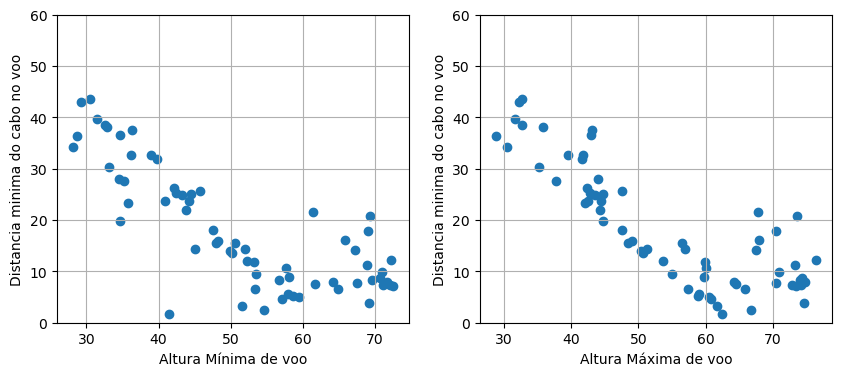

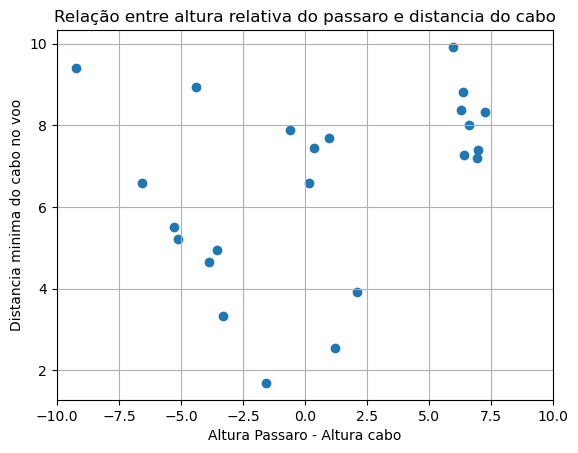

In [99]:
min_heights = [] # altura minima por voo
max_heights = [] # alutra maxima por voo
min_dists_cable = [] # minima distancia ate o cabo por voo
delta_height = []
for trac in tracking_3d:
    if len(tracking_3d[trac]['Height']) == 0:
        print(trac)
        continue

    min_heights.append([min(tracking_3d[trac]['Height'])])
    max_heights.append([max(tracking_3d[trac]['Height'])])
    min_dists_cable.append(min(tracking_3d[trac]['Dist_cable']))

    # find point where the bird was when we have 
    index_min = tracking_3d[trac]['Dist_cable'].index(min_dists_cable[-1])
    y_min_dist = tracking_3d[trac]['Cable_y'][index_min]
    z_catenary = catenaria(y_min_dist-L/2)-a_cat+altura_torre-flecha


    delta_height.append(tracking_3d[trac]['Height'][index_min] - \
                        z_catenary)


plot.figure(figsize=[10,4])
plot.subplot(121)
plot.scatter(min_heights,min_dists_cable)
plot.xlabel('Altura Mínima de voo')
plot.ylabel('Distancia minima do cabo no voo')
plot.ylim([0,60])
plot.grid()
plot.subplot(122)
plot.scatter(max_heights,min_dists_cable)
plot.xlabel('Altura Máxima de voo')
plot.ylabel('Distancia minima do cabo no voo')
plot.ylim([0,60])
plot.grid()
plot.show()

min_dists_cable = np.array(min_dists_cable)
delta_height = np.array(delta_height)
th = 10

plot.scatter(delta_height[min_dists_cable<th],min_dists_cable[min_dists_cable<th]
)
plot.title("Relação entre altura relativa do passaro e distancia do cabo")
plot.xlabel('Altura Passaro - Altura cabo')
plot.ylabel('Distancia minima do cabo no voo')
# plot.ylim([0,60])
plot.xlim([-10,10])
plot.grid()
plot.show()

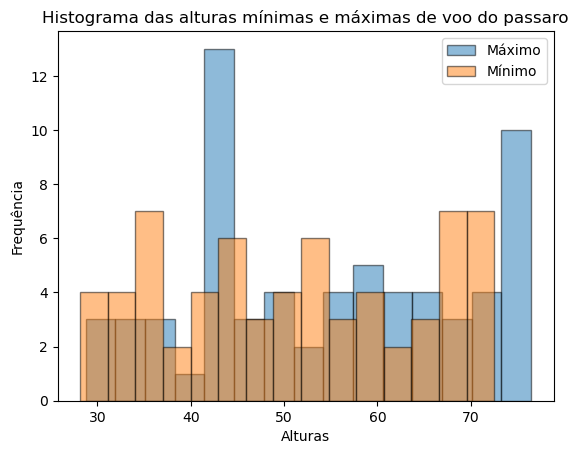

In [69]:
plot.hist((np.array(max_heights).reshape(1,-1))[0], bins=15,edgecolor='black',alpha=.5,label="Máximo")
plot.hist((np.array(min_heights).reshape(1,-1))[0], bins=15,edgecolor='black',alpha=.5,label="Mínimo")

plot.xlabel("Alturas")
plot.ylabel("Frequência")
plot.title("Histograma das alturas mínimas e máximas de voo do passaro")
plot.legend()
plot.show()


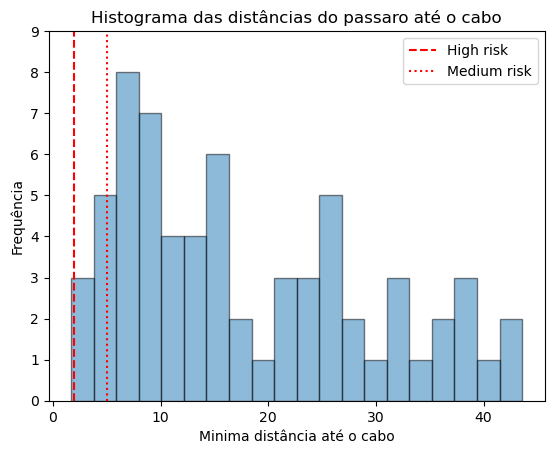

In [88]:
th_1 = 2
th_2 = 5

plot.hist((np.array(min_dists_cable).reshape(1,-1))[0], bins=20,edgecolor='black',alpha=.5)
plot.xlabel("Minima distância até o cabo")
plot.ylabel("Frequência")
plot.title("Histograma das distâncias do passaro até o cabo")
plot.plot([th_1,th_1],[0,13],'--r',label='High risk')
plot.plot([th_2,th_2],[0,13],':r',label='Medium risk')
plot.legend()
plot.ylim([0,9])
plot.show()

In [101]:
th_1 = 2
th_2 = 5
high_risk = sum((np.array(min_dists_cable).reshape(1,-1))[0]<th_1) 
medium_risk = sum((np.array(min_dists_cable).reshape(1,-1))[0]<th_2) - high_risk
count_birds = len((np.array(min_dists_cable).reshape(1,-1))[0])
low_risk = count_birds - medium_risk - high_risk
print(f"Alto risco: {high_risk} or {100*high_risk/count_birds:,.2f} %")
print(f"Medio risco: {medium_risk} or {100*medium_risk/count_birds:,.2f} %")
print(f"Baixo risco: {low_risk} or {100*low_risk/count_birds:,.2f} %")

print(f"Numero de pássaros: {count_birds}")

Alto risco: 1 or 1.52 %
Medio risco: 5 or 7.58 %
Baixo risco: 60 or 90.91 %
Numero de pássaros: 66


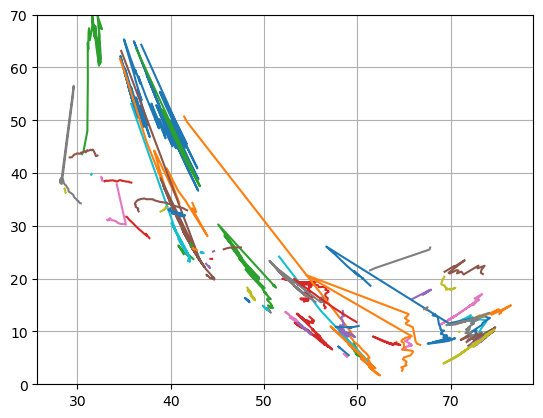

In [41]:
for trac in tracking_3d:
    plot.plot(tracking_3d[trac]['Height'],tracking_3d[trac]['Dist_cable'])

plot.grid()
plot.ylim([0,70])
plot.show()



## Check region of possible points in image

In [9]:
from scipy.spatial import ConvexHull,convex_hull_plot_2d
import time

In [10]:
xyz_rotated

array([[-33.51293941],
       [340.13692762],
       [ 16.66704913]])

In [11]:
xyz_rotated.reshape(1,-1)

array([[-33.51293941, 340.13692762,  16.66704913]])

In [12]:
vertices_x = []
vertices_y = []

h,w = (1080, 1920)
distance_range = np.arange(80,310,20)
img_border_in_3d = []
border_distance_to_cable = []
total_points = []

NUM_STEP = 8
# for h_b, w_b in border_coordinates:
for i, w_b in enumerate(np.arange(0,w+1,w/NUM_STEP)):
    start = time.time()
    # print(w_b)
    img_border_in_3d = []
    border_distance_to_cable = []
    img_border_in_3d_floor = []
    for h_b in np.arange(0,h+1,h/NUM_STEP):


        coordinates = (w_b, h_b, w_b, h_b)
        theta_azimute, phi_polar = get_angles(data, coordinates)
        vector_angles.append((theta_azimute, phi_polar, radius))

        for radius in distance_range:
            x = radius * np.sin(phi_polar) * np.cos(theta_azimute)
            y = radius * np.sin(phi_polar) * np.sin(theta_azimute)
            z = radius * np.cos(phi_polar) #### CHECK
            xyz_rotated = rotatation_matrix@np.array([[x],[y],[z]])
            if abs(np.sqrt(x**2+y**2+z**2) - radius) > 1:
                print('error')
                break
            print(np.sqrt(xyz_rotated[0]**2+xyz_rotated[1]**2+xyz_rotated[2]**2)[0] - radius)
            if abs(np.sqrt(xyz_rotated[0]**2+xyz_rotated[1]**2+xyz_rotated[2]**2)[0] - radius) > 1:
                print('error')
                break
            img_border_in_3d.append((xyz_rotated.reshape(1,-1))[0])
            img_border_in_3d_floor.append((xyz_rotated.reshape(1,-1))[0] + [0,0,altura_camera])

    border_distance_to_cable,_ = distances_to_catenary(img_border_in_3d_floor)
    border_height              = [aaa[2] + altura_camera for aaa in img_border_in_3d]

    points = [[i[0],i[1]] for i in zip(border_distance_to_cable,border_height)]
    total_points += points
    # Find the convex hull
    hull = ConvexHull(points)
    # hull.close()
    # Get the indices of the vertices that form the hull
    hull_indices = hull.vertices
    hull_vertices_x = [points[h][0] for h in hull_indices] + [points[0][0]]
    hull_vertices_y = [points[h][1] for h in hull_indices] + [points[0][1]]

    vertices_x.append(hull_vertices_x)
    vertices_y.append(hull_vertices_y)
    stop = time.time()
    print(f"{i} of {len(np.arange(0, w+1, w/NUM_STEP))} in {stop-start:.2f} seconds  ") #,end='\r')

0.0
0.0
1.4210854715202004e-14
0.0
0.0
0.0
0.0
0.0
2.842170943040401e-14
0.0
0.0
0.0
0.0
-2.842170943040401e-14
-1.4210854715202004e-14
0.0
0.0
0.0
-5.684341886080802e-14
-2.842170943040401e-14
-2.842170943040401e-14
0.0
0.0
5.684341886080802e-14
-1.4210854715202004e-14
-1.4210854715202004e-14
-1.4210854715202004e-14
0.0
-2.842170943040401e-14
0.0
-2.842170943040401e-14
-2.842170943040401e-14
-2.842170943040401e-14
0.0
0.0
0.0
0.0
-1.4210854715202004e-14
-1.4210854715202004e-14
0.0
0.0
0.0
-2.842170943040401e-14
2.842170943040401e-14
-2.842170943040401e-14
0.0
0.0
0.0
0.0
-1.4210854715202004e-14
-1.4210854715202004e-14
-2.842170943040401e-14
0.0
-2.842170943040401e-14
-2.842170943040401e-14
2.842170943040401e-14
-2.842170943040401e-14
-5.684341886080802e-14
-5.684341886080802e-14
0.0
-1.4210854715202004e-14
-1.4210854715202004e-14
-1.4210854715202004e-14
0.0
-2.842170943040401e-14
-2.842170943040401e-14
-2.842170943040401e-14
-2.842170943040401e-14
-2.842170943040401e-14
0.0
0.0
-5.684

In [13]:
dfDistance.head()

,Unnamed: 0,coordinates_x1,coordinates_y1,coordinates_x2,coordinates_y2,current_frame,track_id,video_file,bird_distance,bird_Depth,coefs,ref_depth_values,ref_distance_values,ref_choosen_points,ref_circles,ignore
0,0,1006.797363,644.195557,1031.176758,660.926025,3.0,1793.0,10-10-2024_17-32-01_track_467_cam_0.avi_track_...,294.44363,0.782513,"[array([-59.224506], dtype=float32), 340.7876]",[[4.08603 ]\n [2.988288 ]\n [2.0437672]\n [1....,[ 97.03452097 132.67746731 182.81089 238.42...,[],10-10-2024_09-02-35_track_275_cam_0.png,1
1,1,1001.651794,649.700684,1026.556274,667.559937,4.0,1793.0,10-10-2024_17-32-01_track_467_cam_0.avi_track_...,293.07147,0.781194,"[array([-59.59687], dtype=float32), 339.62817]",[[4.0546107]\n [2.9335089]\n [2.0132427]\n [1....,[ 97.03452097 132.67746731 182.81089 238.42...,[],10-10-2024_09-02-35_track_275_cam_0.png,1
2,2,995.907166,658.067749,1019.154236,675.485168,5.0,1793.0,10-10-2024_17-32-01_track_467_cam_0.avi_track_...,295.34420,0.735534,"[array([-59.2811], dtype=float32), 338.94745]",[[4.054403 ]\n [2.936049 ]\n [2.0111525]\n [1....,[ 97.03452097 132.67746731 182.81089 238.42...,[],10-10-2024_09-02-35_track_275_cam_0.png,1
3,3,991.941406,663.454102,1015.261780,680.538208,6.0,1793.0,10-10-2024_17-32-01_track_467_cam_0.avi_track_...,298.47046,0.704196,"[array([-59.50448], dtype=float32), 340.3733]",[[4.072793 ]\n [2.9497092]\n [2.0280147]\n [1....,[ 97.03452097 132.67746731 182.81089 238.42...,[],10-10-2024_09-02-35_track_275_cam_0.png,1
4,4,987.898376,671.367004,1009.430298,687.580566,7.0,1793.0,10-10-2024_17-32-01_track_467_cam_0.avi_track_...,299.13443,0.689788,"[array([-59.187405], dtype=float32), 339.96118]",[[4.104521 ]\n [2.9633124]\n [2.0247164]\n [1....,[ 97.03452097 132.67746731 182.81089 238.42...,[],10-10-2024_09-02-35_track_275_cam_0.png,1


In [33]:
def transform_cartesian_to_polar(xyz):
    x,y,z = xyz
    r = np.sqrt(x**2 + y**2 + z**2)
    phi_polar = np.arccos(z / r)
    theta_azimute = np.sign(y) * np.arccos(x / (x**2 + y**2))

    return r, theta_azimute, phi_polar

for y in [100,200,300]:
    _,theta_azimute_ref, phi_polar_ref = transform_cartesian_to_polar( (-metade_horizontal,y, height_catenary(y) ) )
    print(transform_cartesian_to_polar( (-metade_horizontal,y, height_catenary(y) ) ))
    y_ref = y

(141.13447113686095, 1.5721976711717651, 0.7977002871305796)
(215.68983297825622, 1.571152008468797, 1.1933928115079484)
(307.8688400878943, 1.5709548554896422, 1.3491976540731763)


In [32]:
NUM_STEP = 1920
h,w = (1920, 1920)

radius = 307.86
for i, w_b in enumerate(np.arange(0,w+1,w/NUM_STEP)):
    for h_b in np.arange(0,h+1,h/NUM_STEP):
        coordinates = (w_b, h_b, w_b, h_b)
        theta_azimute, phi_polar = get_angles(data, coordinates)
        if abs(theta_azimute - theta_azimute_ref) < 1e-5 or abs(phi_polar-phi_polar_ref)<1e-5:
            print(w_b, h_b  )
            x = radius * np.sin(phi_polar) * np.cos(theta_azimute)
            y = radius * np.sin(phi_polar) * np.sin(theta_azimute)
            z = radius * np.cos(phi_polar) #### CHECK
            print((-metade_horizontal,y_ref, height_catenary(y_ref) ))
            print(x,y,z)
            break

        # for radius in distance_range:
        #     x = radius * np.sin(phi_polar) * np.cos(theta_azimute)
        #     y = radius * np.sin(phi_polar) * np.sin(theta_azimute)
        #     z = radius * np.cos(phi_polar) #### CHECK
        #     xyz_rotated = rotatation_matrix@np.array([[x],[y],[z]])
        #     x_bird, y_bird, z_bird = (xyz_rotated.reshape(1,-1))[0] + [0,0,altura_camera]
        #     dist = distance_by_vector(x_bird, y_bird, z_bird, -metade_horizontal, N=1000)
        #     if dist.x[0] < 20:
        #         break


In [16]:
# for i, w_b in enumerate(np.arange(0,w+1,w/NUM_STEP)):
#     start = time.time()
#     # print(w_b)
#     for j, h_b in enumerate(np.arange(0,h+1,h/NUM_STEP)):
#         iii = i*len(np.arange(0,h+1,h/NUM_STEP)) + j
#         plot.plot(vertices_x[iii], vertices_y[iii],'*:')
#         plot.title(f"Coordenadas ({h_b},{w_b})")
#         plot.xlim([0,70]), plot.ylim([0,100])
#         plot.xlabel("Alturas")
#         plot.ylabel("Distancias from cable")
#         plot.show()



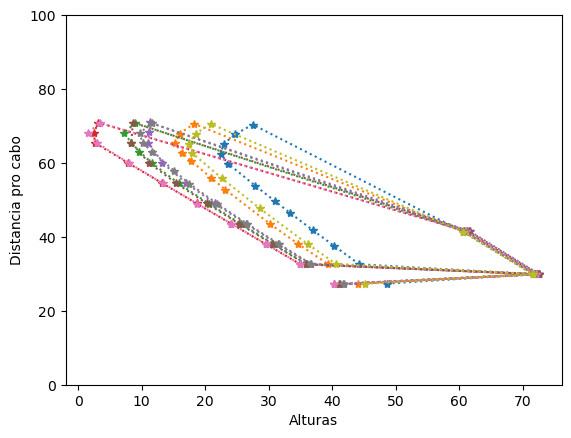

In [17]:
for i in range(len(vertices_x)):
    plot.plot(vertices_x[i], vertices_y[i],'*:')
plot.xlabel('Alturas')
plot.ylabel('Distancia pro cabo')
# plot.xlim([70,100])
plot.ylim([0,100])
plot.show()

In [18]:
points = [[i[0],i[1]] for i in zip(vertices_x[0], vertices_y[0])]
total_points = []
for i in range(len(vertices_x)):
    points = [[xy[0],xy[1]] for xy in zip(vertices_x[i], vertices_y[i])]
    total_points += points

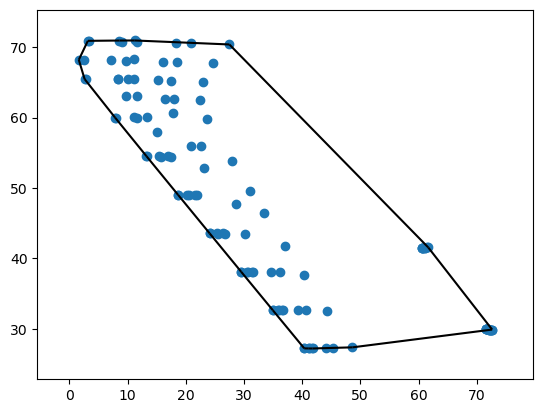

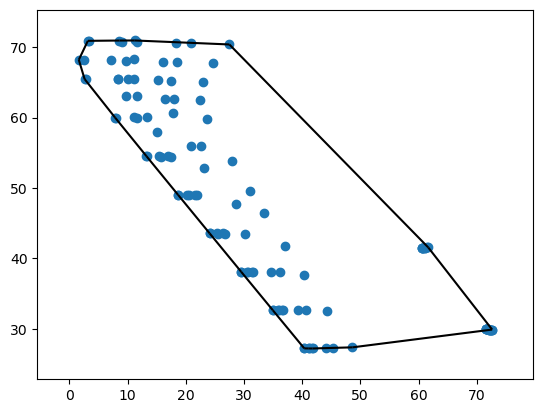

In [19]:
# Find the convex hull
hull = ConvexHull(total_points)
# hull.close()

# Get the indices of the vertices that form the hull
hull_indices = hull.vertices

# Plot the convex hull without points
convex_hull_plot_2d(hull)

# Show the plot
# plot.show()

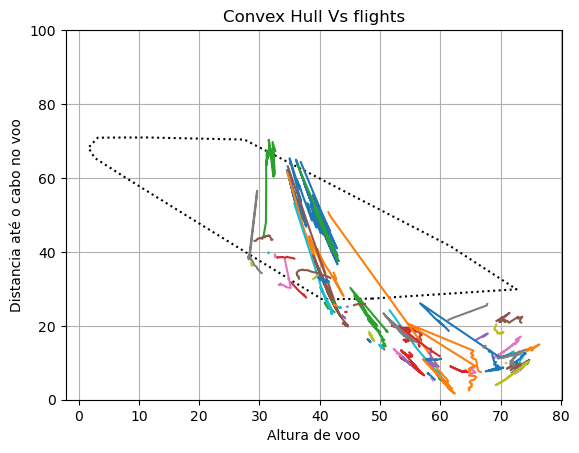

In [20]:
hull_vertices_x = [total_points[h][0] for h in hull_indices] #+ [total_points[0][0]]
hull_vertices_y = [total_points[h][1] for h in hull_indices] #+ [total_points[0][1]]
hull_vertices_x.append(hull_vertices_x[0])
hull_vertices_y.append(hull_vertices_y[0])

# Plot only the convex hull (no points)
plot.figure()
plot.plot(hull_vertices_x,hull_vertices_y,'k:')
for trac in tracking_3d:
    plot.plot(tracking_3d[trac]['Height'],tracking_3d[trac]['Dist_cable'])

plot.grid()
plot.title("Convex Hull Vs flights")
plot.xlabel('Altura de voo')
plot.ylabel('Distancia até o cabo no voo')
plot.ylim([0,100])
plot.show()

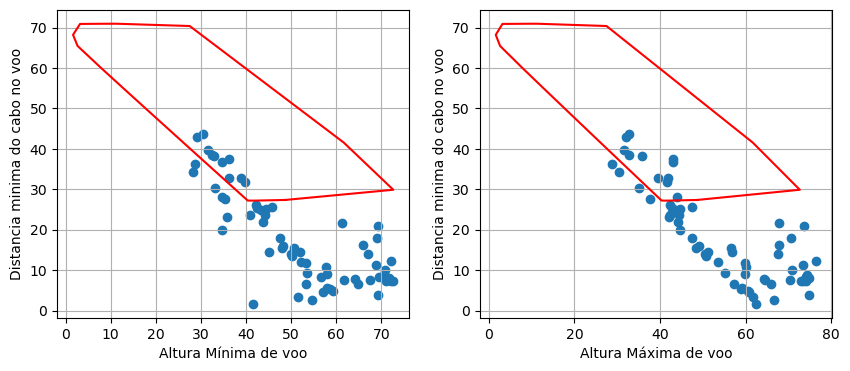

In [21]:
plot.figure(figsize=[10,4])
plot.subplot(121)
plot.scatter(min_heights,min_dists_cable)
plot.plot(hull_vertices_x,hull_vertices_y,c='r')
plot.xlabel('Altura Mínima de voo')
plot.ylabel('Distancia minima do cabo no voo')
plot.grid()
plot.subplot(122)
plot.scatter(max_heights,min_dists_cable)
plot.plot(hull_vertices_x,hull_vertices_y,c='r')
plot.xlabel('Altura Máxima de voo')
plot.ylabel('Distancia minima do cabo no voo')
plot.grid()

plot.show()

## Plots for X, Y, Z

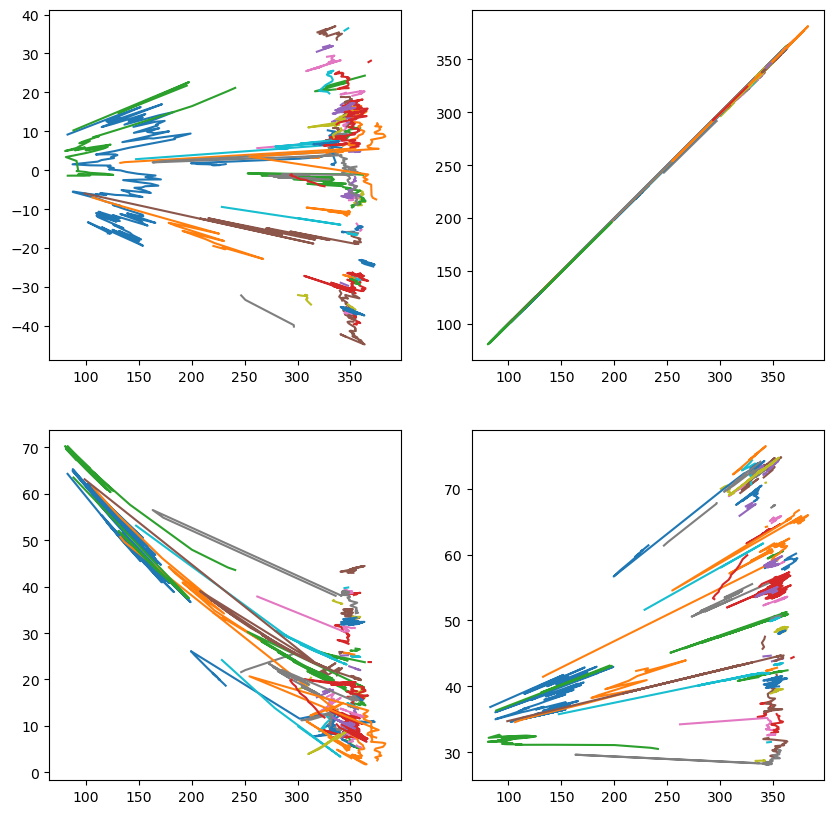

In [22]:
plot.figure(figsize=(10,10))
ax1 = plot.subplot(221)
ax2 = plot.subplot(222)
ax3 = plot.subplot(223)
ax4 = plot.subplot(224)

for trac in tracking_3d:
    x = [a[0] for a in tracking_3d[trac]['Cartesian']]
    y = [a[1] for a in tracking_3d[trac]['Cartesian']]
    z = [a[2] for a in tracking_3d[trac]['Cartesian']]
    r = tracking_3d[trac]['radius']
    h = tracking_3d[trac]['Height']
    d = tracking_3d[trac]['Dist_cable']
    ax1.plot(r,x)
    ax2.plot(r,y)
    ax3.plot(r,d)
    ax4.plot(r,h)
plot.show()